### How to use

#### Step 1: Run the Metrics Functions cells

In [1]:
import numpy as np
import editdistance
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

def jaccard_similarity(text1, text2):

    set1 = set(text1.split())
    set2 = set(text2.split())
    
    return len(set1.intersection(set2)) / len(set1.union(set2))


def cosine_sim(text1, text2):

    vectorizer = CountVectorizer().fit_transform([text1, text2])
    vectors = vectorizer.toarray()
    
    cos_sim = cosine_similarity(vectors)
    
    return cos_sim[0][1]

def edit_score(text1, text2):

    return 1 - (editdistance.eval(text1, text2) / max(len(text1), len(text2)))

def ngrams(input, n):

    input = input.lower().split(' ')

    output = []

    for i in range(len(input)-n+1):
        output.append(tuple(input[i:i+n]))

    return output

def ngram_sim(text1, text2, n):

    ng1 = set(ngrams(text1, n))
    ng2 = set(ngrams(text2, n))
    
    common_ngrams = ng1.intersection(ng2)

    return (2*len(common_ngrams))/(len(ng1)+len(ng2))

def longestSubstringFinder(string1, string2):

    answer = ""
    len1, len2 = len(string1), len(string2)

    for i in range(len1):

        for j in range(len2):

            lcs_temp = 0
            match = ''

            while ((i+lcs_temp < len1) and (j+lcs_temp<len2) and string1[i+lcs_temp] == string2[j+lcs_temp]):
                match += string2[j+lcs_temp]
                lcs_temp += 1

            if len(match) > len(answer):
                answer = match

    return answer

def longest_substring_metric(string1, string2):

    return len(longestSubstringFinder(string1, string2)) / max(len(string1), len(string2))

In [2]:
import editdistance
from ngram import NGram 

precision = 2
threshold = .95

def compute_metrics_for_articles(table, article_number, journal, article_type, manual, scraped, n_title=1, n_text=1):
    
    # ngram_similarity = NGram.compare(manual, scraped, N=n_title) if article_type == 'Title' else NGram.compare(manual, scraped, N=n_text)
    ngram_similarity = ngram_sim(manual, scraped, n=n_title) if article_type == 'Title' else ngram_sim(manual, scraped, n=n_text)
    
    edit_dist = editdistance.eval(manual, scraped)
    edit_sim = edit_score(manual, scraped)

    cos_sim = cosine_sim(manual, scraped)

    lgst_substr = longest_substring_metric(manual, scraped)
    
    avg_similarity = (ngram_similarity + edit_sim) / 2
    #avg_similarity = (ngram_similarity + edit_sim + cos_sim) / 3
    
    mark = 'X' if avg_similarity >= threshold else '-'

    table.append([
        article_number,
        journal,
        article_type,
        ngram_similarity,
        f'{edit_dist} ({edit_sim:.{precision}f})',
        #cos_sim,
        lgst_substr,
        avg_similarity,
        mark
    ])

    return avg_similarity


#### Step 2: Run the Print Params cells

In [3]:
from urllib.parse import urlparse


def get_journal_name(url):

    second_level_domains = ['com.cn', 'co.uk', 'org.cn', 'net.cn', 'fr', 'de', 'es']
    
    parsed_url = urlparse(url)
    domain_parts = parsed_url.netloc.split('.')
    
    if len(domain_parts) > 2 and '.'.join(domain_parts[-2:]) in second_level_domains:
        return domain_parts[-3]

    elif len(domain_parts) > 2:
        return domain_parts[-2]
        
    else:
        return domain_parts[0]

In [4]:
from tabulate import tabulate

headers = [
    'Article #', 
    'Journal Name', 
    'Type', 
    'N-gram Similarity', 
    'Edit Distance (Score)', 
    #'Cosine Similarity',
    'Longest Sub-string Score',
    'Combined Syntaxic Similarity (CSS)', 
    f'CSS > {threshold}', 
]

def print_similarity_results(table):
    
    print(
        tabulate(
            table, 
            headers=headers, 
            tablefmt='grid', 
            floatfmt=f'.{precision}f', 
            colalign=('center','center', 'center', 'center', 'center', 'center', 'center', 'center')
        )
    )

#### Step 3: Run on Scraped Data and compare to Test Data

In [5]:
import numpy as np
import pandas as pd

test_set_df = pd.read_csv('text-mining-articles-scraping - Feuille 1.csv')

scraped_df = pd.read_csv('results.csv')

merged_df = scraped_df.merge(test_set_df, on=['url'], suffixes=['_scraped', '_test'])

all_titles = merged_df['title_scraped'].replace(np.nan, "").replace('\n', ' ', regex=True)
all_texts = merged_df['content'].replace('\n', ' ', regex=True)

In [6]:
from statistics import mean, median

journals = merged_df['url'].apply(get_journal_name).tolist()

titles = merged_df['title_test'].replace('\n', ' ', regex=True).tolist()
contents = merged_df['all'].replace('\n', ' ', regex=True).tolist()

table = []
final_title_scores = []
final_text_scores = []

for i in range(len(merged_df)):
        
    journal = journals[i]
    title = titles[i]
    content = contents[i]
        
    final_title_scores.append(compute_metrics_for_articles(table, i+1, journal, 'Title', title, all_titles[i], 1, 1))
    final_text_scores.append(compute_metrics_for_articles(table, i+1, journal, 'Content', content, all_texts[i], 1, 1))

print(f"Average CSS over all titles: {mean(final_title_scores):.{precision}f}")
print(f"Median CSS over all titles: {median(final_title_scores):.{precision}f}\n")
print(f"Average CSS over all texts: {mean(final_text_scores):.{precision}f}")
print(f"Median CSS over all texts: {median(final_text_scores):.{precision}f}\n")
print_similarity_results(table)


Average CSS over all titles: 0.83
Median CSS over all titles: 0.89

Average CSS over all texts: 0.87
Median CSS over all texts: 0.94

+-------------+----------------+---------+---------------------+-------------------------+----------------------------+--------------------------------------+--------------+
|  Article #  |  Journal Name  |  Type   |  N-gram Similarity  |  Edit Distance (Score)  |  Longest Sub-string Score  |  Combined Syntaxic Similarity (CSS)  |  CSS > 0.95  |
+=============+================+=========+=====================+=========================+============================+======================================+==============+
|      1      |    nytimes     |  Title  |        0.32         |        55 (0.37)        |            0.22            |                 0.34                 |      -       |
+-------------+----------------+---------+---------------------+-------------------------+----------------------------+--------------------------------------+------------

In [11]:
r_df = pd.DataFrame(table)
r_df.columns = headers
r_df.tail(5)

,Article #,Journal Name,Type,N-gram Similarity,Edit Distance (Score),Longest Sub-string Score,Combined Syntaxic Similarity (CSS),CSS > 0.95
59,30,lapresse,Content,0.998805,33 (0.99),0.344361,0.995969,X
60,31,lapresse,Title,0.631579,45 (0.42),0.423077,0.527328,-
61,31,lapresse,Content,0.998723,14 (1.00),0.526853,0.997904,X
62,32,lapresse,Title,0.666667,36 (0.44),0.437500,0.552083,-
63,32,lapresse,Content,0.975577,660 (0.94),0.222285,0.956837,X


In [16]:
r_df['Longest Sub-string Score'].mean()

0.5567154494599358

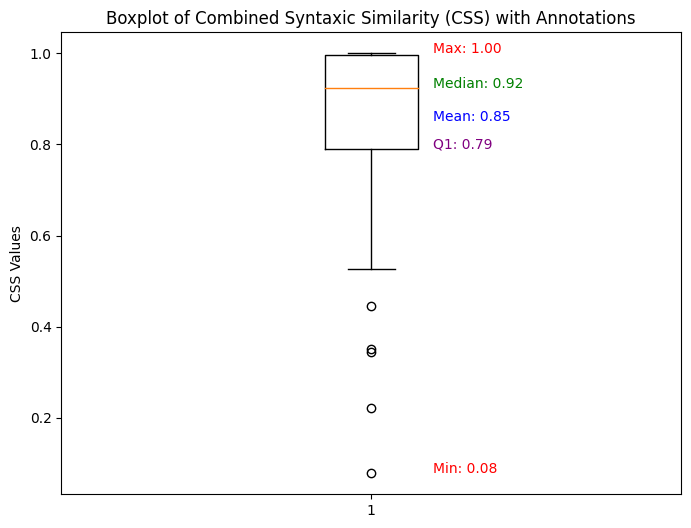

In [12]:
import matplotlib.pyplot as plt

data = r_df['Combined Syntaxic Similarity (CSS)']

mean_value = data.mean()
median_value = data.median()
q1 = data.quantile(0.25)
q3 = data.quantile(0.75)
min_value = data.min()
max_value = data.max()

plt.figure(figsize=(8, 6))
plt.boxplot(data)

# Annotating the plot with key statistics
plt.text(1.1, mean_value, f'Mean: {mean_value:.2f}', color='blue', fontsize=10)
plt.text(1.1, median_value, f'Median: {median_value:.2f}', color='green', fontsize=10)
plt.text(1.1, q1, f'Q1: {q1:.2f}', color='purple', fontsize=10)
# plt.text(1.1, q3, f'Q3: {q3:.2f}', color='purple', fontsize=10)
plt.text(1.1, min_value, f'Min: {min_value:.2f}', color='red', fontsize=10)
plt.text(1.1, max_value, f'Max: {max_value:.2f}', color='red', fontsize=10)

# Displaying the plot
plt.title('Boxplot of Combined Syntaxic Similarity (CSS) with Annotations')
plt.ylabel('CSS Values')
plt.show()

In [13]:
r_df['Longest Sub-string Score'].mean()

0.5567154494599358